## Obtain data

In [1]:
!wget https://d396qusza40orc.cloudfront.net/dataminingcapstone/YelpDataset/yelp_dataset.tar.gz
!tar -xvf /kaggle/working/yelp_dataset.tar.gz

--2024-03-16 12:26:52--  https://d396qusza40orc.cloudfront.net/dataminingcapstone/YelpDataset/yelp_dataset.tar.gz
Resolving d396qusza40orc.cloudfront.net (d396qusza40orc.cloudfront.net)... 52.84.160.159, 52.84.160.76, 52.84.160.182, ...
Connecting to d396qusza40orc.cloudfront.net (d396qusza40orc.cloudfront.net)|52.84.160.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443445047 (423M) [application/x-gzip]
Saving to: 'yelp_dataset.tar.gz'

yelp_dataset.tar.gz 100%[===================>] 422.90M  50.4MB/s    in 8.5s    

2024-03-16 12:27:01 (49.6 MB/s) - 'yelp_dataset.tar.gz' saved [443445047/443445047]

yelp_dataset_challenge_academic_dataset/
yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_user.json
yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json
yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_checkin.json
yelp_dataset_challenge_academic_dataset/Dataset_Challenge_Academic_Dataset_Agreement.pdf
yelp_datas

## Dependencies

In [7]:
!pip install gensim
# !pip install

In [14]:
from gensim import corpora, matutils
from gensim.models import LdaModel
import json
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


### preprocessing

In [15]:
np.random.seed(1875)

In [30]:
# transforming to df
# REVIEW_SOURCE = "/kaggle/working/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json"
reviews_df = pd.read_json(REVIEW_SOURCE, lines=True)
reviews_part_df = reviews_df.sample(frac=0.1, random_state=1875)
reviews_part_df.head()

,votes,user_id,review_id,stars,date,text,type,business_id
25787,"{'funny': 2, 'useful': 7, 'cool': 5}",kxF7St0L3F_qVVl5ZT27hA,np-P6Gjpii4bcPEXZtEhUg,4,2008-06-17,I was in town and my friend wanted to take me ...,review,SDwYQ6eSu1htn8vHWv128g
690156,"{'funny': 0, 'useful': 0, 'cool': 0}",_xvr2TFYAMJgBOJnG7Irjg,IVWUlDVhaNQc252mD23Npw,2,2011-09-01,Frozen hot chocolate... what a disappointment....,review,Xhg93cMdemu5pAMkDoEdtQ
569162,"{'funny': 2, 'useful': 4, 'cool': 4}",waD2euOMPTnTzQ0thq3H6Q,OzrrhvVr4XWQ0yscmXBt9Q,5,2008-02-26,"$1 Sushi, wtf??!?!? Ok, so I tried this place...",review,M42zwm3xFkG6qnZsnTtt2Q
20732,"{'funny': 0, 'useful': 0, 'cool': 0}",u-IdKmC7u9AFlypEPi_16g,9EYrTqTJbRoYxxHGkRCvWQ,5,2011-09-18,Awesome customer service always has what i nee...,review,ZDlA4SPGz-fs_mjE6wVWnQ
344534,"{'funny': 6, 'useful': 7, 'cool': 4}",qqtmFGhyyHc37coT4qJxaw,v5bP03IORpU9vOGTGtb_lg,5,2013-02-26,"Another night at Maggiano's, and another excel...",review,-2n-OHbbwIv3SY8RP9bgTQ


In [31]:
reviews_part_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112546 entries, 25787 to 425794
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   votes        112546 non-null  object        
 1   user_id      112546 non-null  object        
 2   review_id    112546 non-null  object        
 3   stars        112546 non-null  int64         
 4   date         112546 non-null  datetime64[ns]
 5   text         112546 non-null  object        
 6   type         112546 non-null  object        
 7   business_id  112546 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 7.7+ MB


In [35]:
reviews_part_lst = reviews_part_df['text'].to_list()

### Task1

### Helper functions

In [110]:
def train_lda(lst, num_topics):
    # tfidf vectorize
    tfidfVectorizer = TfidfVectorizer(stop_words='english')
    vec = tfidfVectorizer.fit_transform(lst)

    # lda training
    dictionary = gensim.corpora.Dictionary([tfidfVectorizer.get_feature_names_out()])  
    corpus = matutils.Sparse2Corpus(vec, documents_columns=False)
    lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics)
    return lda

# by gpt: transform list to df
def topics_lst2df(lst):
    topic_ids = []
    weights = []
    words = []

    for item in lst:
        topic_id, word_weights = item
        words_list = word_weights.split(" + ")
        weight_list = []
        word_list = []
        for word_weight in words_list:
            topic_ids.append(topic_id)

            weight, word = word_weight.split("*")
            weight = float(weight[1:])
            word = word.strip('"')
            weights.append(weight)
            words.append(word)

    df = pd.DataFrame({
        'topic_ids': topic_ids,
        'weights': weights,
        'words': words
    })
    return df

# randomly plot 5 words of 5 topics
def plot_topics(lst):
    df = topics_lst2df(lst)
    plot = sns.catplot(data=df, x='words', y='weights', hue='topic_ids', kind='bar')
    plot.set_xticklabels(rotation=90)

In [72]:
topic_lda = topics_lst_lda(reviews_lst, 20)

In [108]:
topic_lst = topic_lda.show_topics(num_topics=5, num_words=5)
topic_lst

[(18,
  '0.010*"equipment" + 0.007*"create" + 0.007*"popcorn" + 0.007*"root" + 0.006*"toys"'),
 (14,
  '0.007*"pot" + 0.006*"ravioli" + 0.006*"benedict" + 0.006*"tire" + 0.006*"bagel"'),
 (6,
  '0.011*"donuts" + 0.007*"boba" + 0.006*"wash" + 0.006*"dim" + 0.006*"sum"'),
 (4,
  '0.016*"pho" + 0.012*"thai" + 0.012*"curry" + 0.008*"tuna" + 0.005*"pad"'),
 (16,
  '0.013*"ramen" + 0.008*"korean" + 0.007*"philly" + 0.007*"truck" + 0.006*"smoothie"')]

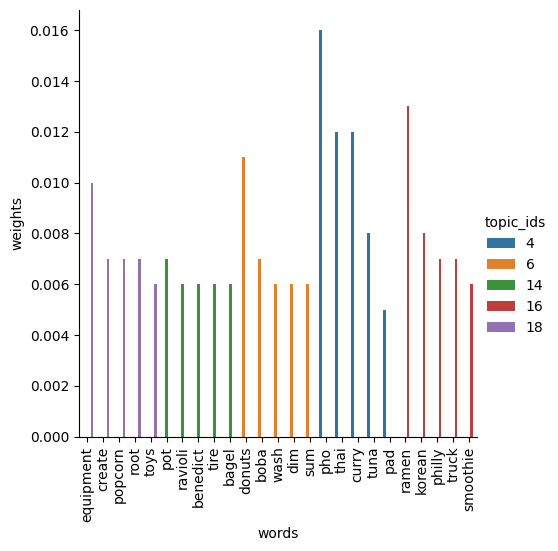

In [111]:
plot_topics(topic_lst)

+ tf-idf for vectorization(dont need to remove stopwords)

### Task 2

### filter dataset
- good_reviews: star >= 3
- bad_reviews: star < 3

In [49]:
bad_reviews_df = reviews_part_df[reviews_df['stars']<3]
good_reviews_df = reviews_part_df[reviews_df['stars']>=3]

bad_reviews_lst = bad_reviews_df['text'].tolist()
good_reviews_lst = good_reviews_df['text'].tolist()



/tmp/ipykernel_33/4025697335.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bad_reviews_df = reviews_part_df[reviews_df['stars']<3]
/tmp/ipykernel_33/4025697335.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  good_reviews_df = reviews_part_df[reviews_df['stars']>=3]


In [59]:
len(good_reviews_lst)

91301

In [112]:
bad_topics_lda = train_lda(bad_reviews_lst, 10)
good_topics_lda = train_lda(good_reviews_lst, 20)

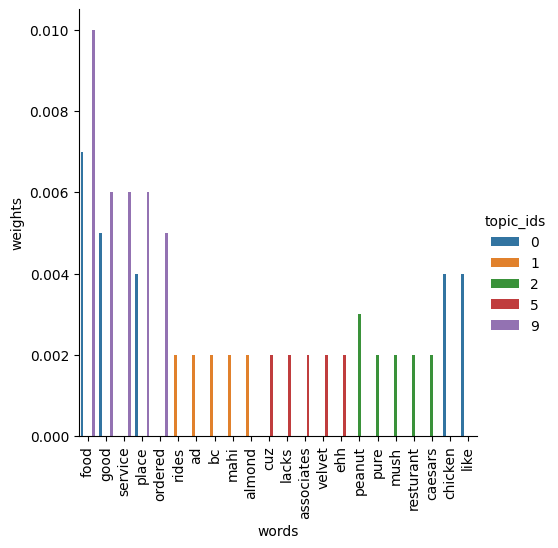

In [113]:
plot_topics(bad_topics_lda.show_topics(num_topics=5, num_words=5))

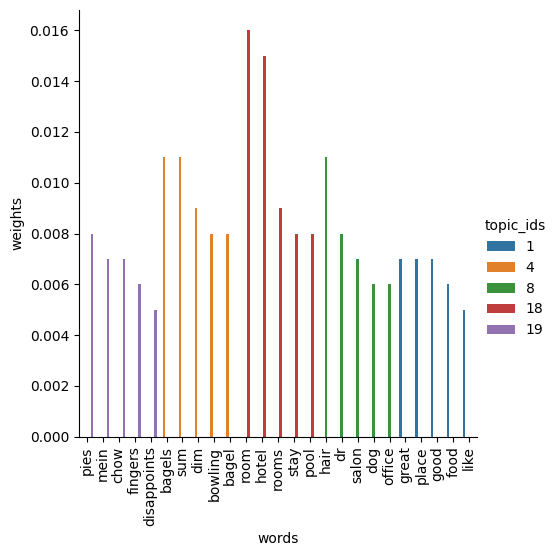

In [114]:
plot_topics(good_topics_lda.show_topics(num_topics=5, num_words=5))